In [ ]:
import pandas as pd 
import numpy as np
from tqdm import tqdm


In [146]:
from preprocess import  preprocess_metadata
from evaluation import evaluate_search_system 
from semantic_search import semantic_search ,enhanced_search, generate_embeddings, build_faiss_index
from utils import convert_embedding_string_to_array, display_search_results

ImportError: cannot import name 'build_faiss_index' from 'semantic_search' (/Users/alvarodelamaza/Desktop/Prosus-AI-DelamazaAlvaro/src/semantic_search.py)

In [ ]:
items = pd.read_csv("../data/5k_items_processed.csv")

## Data loading and cleaning

In [ ]:
queries = pd.read_csv("../data/queries.csv")

test_queries = pd.read_csv("../data/test_queries.csv")
test_queries=list(test_queries['query'])



In [4]:
items

,_id,itemId,itemMetadata,itemProfile,merchantId,jointText,organic,lacFree,vegan,avgBasketPrice,total_orders,reorderRate,embeddings_jointText,jointTextNatural,category_name,embeddings_jointTextNatural
0,6813b2b5b7476b2ec454b7ff,442731c2-144b-4c5c-b81e-e0cf9dfa9630,"{""category_name"":""Alimentos Básicos"",""descript...","{""metrics"":{""avgBasketPrice"":159.89,""coPurchas...",d6cf7b73-c9bb-4c8a-abd6-c1a832bdd461,Macarrão Pena com Ovos Adria 500g Pacote 500g ...,False,False,False,159.89,16,0.00,"[-0.008768842555582523, 0.0031782048754394054,...",Macarrão Pena com Ovos Adria 500g pertencente ...,Alimentos Básicos,"[-0.030683962628245354, 0.006260629277676344, ..."
1,6813b2b5b7476b2ec454b800,4a6d4a8f-c1bf-4457-a448-4a3b5e1eb20c,"{""category_name"":""Doces e Sobremesas"",""descrip...","{""metrics"":{""avgBasketPrice"":182.44,""coPurchas...",d6cf7b73-c9bb-4c8a-abd6-c1a832bdd461,Goplana Squares Pistache 200g Embalagem 200g D...,False,False,False,182.44,1,0.00,"[-0.02953251823782921, -0.03579430282115936, -...",Goplana Squares Pistache 200g pertencente à ca...,Doces e Sobremesas,"[-0.03905845806002617, -0.02474747598171234, -..."
2,6813b2b5b7476b2ec454b801,5380e263-c202-45cf-8eae-81e54573f122,"{""category_name"":""Higiene e Cuidados Pessoais""...","{""metrics"":{""avgBasketPrice"":190.63,""coPurchas...",d6cf7b73-c9bb-4c8a-abd6-c1a832bdd461,Creme para Pentear Boom Definição Intensa Seda...,False,False,False,190.63,3,0.00,"[0.05936675891280174, 0.020629625767469406, -0...",Creme para Pentear Boom Definição Intensa Seda...,Higiene e Cuidados Pessoais,"[0.05090884491801262, 0.03203822299838066, -0...."
3,6813b2b5b7476b2ec454b802,595ce305-ddf5-49fc-9a8c-b50a9ccf6267,"{""category_name"":""Higiene e Cuidados Pessoais""...","{""metrics"":{""avgBasketPrice"":113.56,""coPurchas...",d6cf7b73-c9bb-4c8a-abd6-c1a832bdd461,Desodorante Invisible For Black & White Aeroso...,False,False,False,113.56,3,0.00,"[0.05391239747405052, -0.03024141862988472, -0...",Desodorante Invisible For Black & White Aeroso...,Higiene e Cuidados Pessoais,"[0.04173634201288223, -0.013005441054701805, -..."
4,6813b2b5b7476b2ec454b803,5e2db3a9-1a2c-4462-8aa1-1ed045122e12,"{""category_name"":""Pet Shop"",""description"":""• R...","{""metrics"":{""avgBasketPrice"":223.58,""coPurchas...",d6cf7b73-c9bb-4c8a-abd6-c1a832bdd461,Ração Úmida para Cães Filhotes Frango Ao Molho...,False,False,False,223.58,1,0.00,"[0.06496849656105042, 0.01100705936551094, -0....",Ração Úmida para Cães Filhotes Frango Ao Molho...,Pet Shop,"[0.06125117465853691, 0.011424851603806019, -0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,6813b39eb7476b2ec454cb82,d4fe2d30-a824-4071-8bb7-9e70ab984db6,"{""category_name"":""Croissant & Brezel"",""descrip...","{""metrics"":{""avgBasketPrice"":78.99,""coPurchase...",bf0d36fe-8972-4b66-8247-38aba1254ae1,Croissant de manteiga tipo francês 70g Croisss...,False,False,False,78.99,6,0.17,"[0.0013472569407895207, 0.044463206082582474, ...",Croissant de manteiga tipo francês 70g pertenc...,Croissant & Brezel,"[-0.016537373885512352, 0.050034645944833755, ..."
4996,6813b39eb7476b2ec454cb83,3aeb7744-c99d-43dc-883f-4eec44d7d85b,"{""category_name"":""Lanches Saudáveis"",""descript...","{""metrics"":{""avgBasketPrice"":80.68,""coPurchase...",bf2834a7-754f-48cc-944f-cb14e65d580c,"Lanche Natural Caprese Tomate, rúcula, mussare...",False,False,False,80.68,5,0.33,"[0.0021305966656655073, 0.021863814443349838, ...",Lanche Natural Caprese pertencente à categoria...,Lanches Saudáveis,"[-0.004352240357547998, 0.02388005517423153, -..."
4997,6813b39eb7476b2ec454cb84,cf9963da-6971-4acb-a511-4663a4a500a7,"{""category_name"":""Bebidas"",""description"":""Garr...","{""metrics"":{""avgBasketPrice"":28.2,""coPurchaseI...",bf3d038c-eb28-419e-81c4-a8475bbea9b7,Coca-Cola Original 200ml Garrafa 200ml Bebidas...,False,False,False,28.20,1,0.00,"[0.03415736183524132, -0.008267918601632118, -...",Coca-Cola Original 200ml pertencente à categor...,Bebidas,"[0.00566784292459

## Embedings Generation

### Baselines

In [76]:
embeddings_items =generate_embeddings(items['jointText'])
embeddings_items_natural =generate_embeddings(items['jointTextNatural'])

In [104]:
embeddings_items_query =generate_embeddings(items['similar_queries_expanded'])


In [85]:
items['embeddings_jointText']=embeddings_items
items['embeddings_jointTextNatural']=embeddings_items_natural

In [106]:
items['embeddings_similar_queries_expanded']=embeddings_items_query

In [101]:
items['embeddings_jointText']

0       [-0.008778361603617668, 0.0031805294565856457,...
1       [-0.02957657165825367, -0.03574946150183678, -...
2       [0.05934057757258415, 0.0204414501786232, -0.0...
3       [0.05391239747405052, -0.03024141862988472, -0...
4       [0.06496189534664154, 0.010996992699801922, -0...
                              ...                        
4995    [0.0013733640080317855, 0.04446421191096306, -...
4996    [0.0021264278329908848, 0.02185039408504963, -...
4997    [0.03416566550731659, -0.008275149390101433, -...
4998    [-0.009373484179377556, 0.0012533544795587659,...
4999    [0.03930863365530968, -0.03683339059352875, -0...
Name: embeddings_jointText, Length: 5000, dtype: object

In [103]:
items['similar_queries_expanded']=items['jointText'] + ',Simillar queries: ' + items['similar_queries']

In [107]:
items.to_csv("../data/5k_items_processed.csv", index=False)

In [36]:
query_embedding=generate_embeddings(queries['search_term_pt'])

In [ ]:

item_embeddings = np.array([convert_embedding_string_to_array(emb) for emb in items['embeddings_jointText']])
item_embeddings_natural = np.array([convert_embedding_string_to_array(emb) for emb in items['embeddings_jointTextNatural']])

AttributeError: 'list' object has no attribute 'startswith'

In [78]:
items['embeddings_jointText']=item_embeddings
items['embeddings_jointTextNatural']=item_embeddings_natural

Search Query: 'coca cola'
Top 10 Results:
--------------------------------------------------------------------------------
Rank 1: Coca cola   Lata
  Description: 
  Price: R$5.00
  Category: Refrigerante
  Similarity Score: 0.7092
  No image available
--------------------------------------------------------------------------------
Rank 2: Coca-Cola
  Description: 
  Price: R$0.00
  Category: Bebidas
  Similarity Score: 0.7064
  Image URL: https://static.ifood-static.com.br/image/upload/t_low/pratos/8e7d4a1a-8a6d-44f3-91f4-c698edce5f0a/202109081142_G143_f.png
--------------------------------------------------------------------------------
Rank 3: Coca-Cola
  Description: 
  Price: R$16.00
  Category: Refrigerantes
  Similarity Score: 0.6922
  Image URL: https://static.ifood-static.com.br/image/upload/t_low/pratos/820af392-002c-47b1-bfae-d7ef31743c7f/202410251738_gacxmhpa7dk.jpeg
--------------------------------------------------------------------------------
Rank 4: Coca cola 350ml
  D

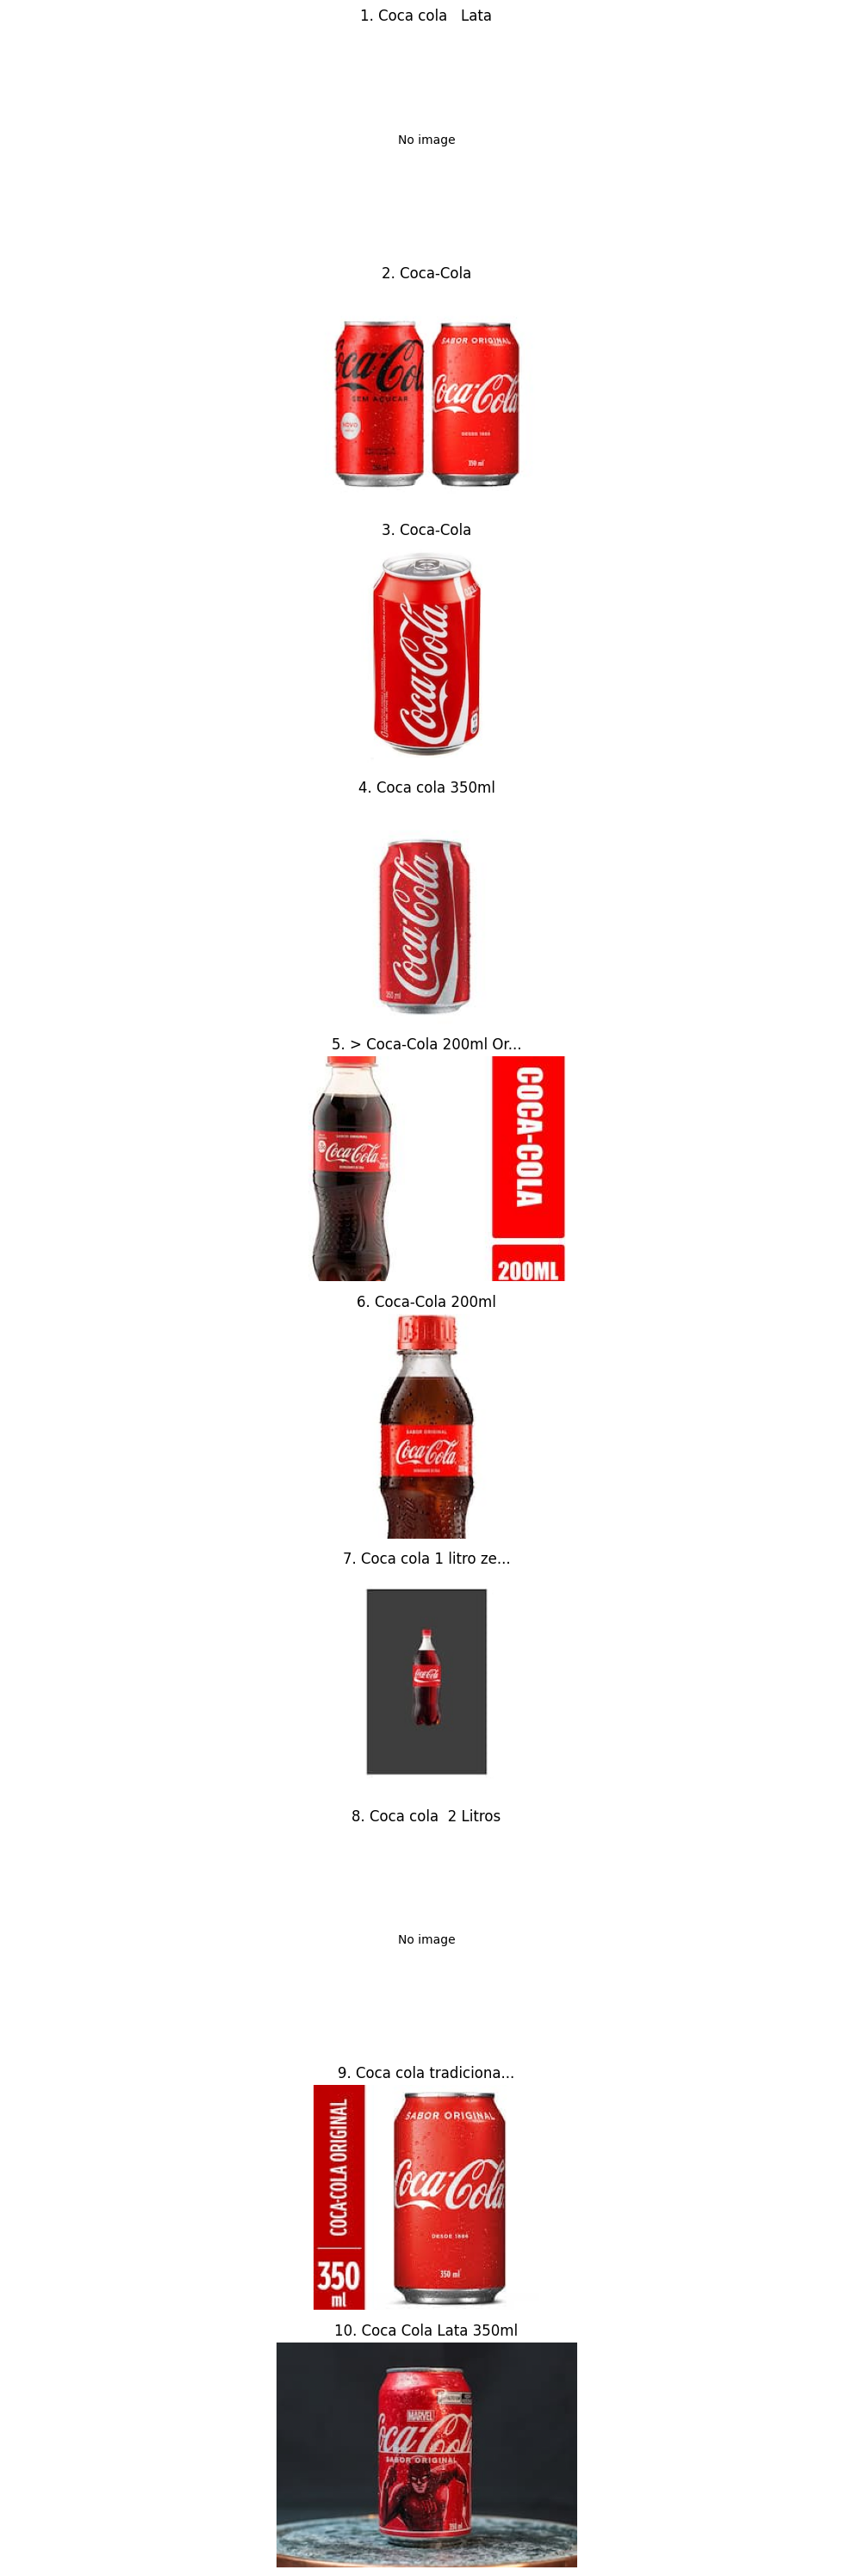

In [29]:
query = "coca cola"
query_embedding = generate_embeddings([query])[0]  # Your embedding function
#item_embeddings = np.array(items['embeddings_jointText'])  # Assuming embeddings are stored in the DataFrame
items_df = items

# Display search results with images
top_indices, top_scores = display_search_results(query, query_embedding, item_embeddings, items_df, top_k=10)


In [ ]:
results=[]
item_embeddings = np.array(embeddings_items_natural) 
for query in test_queries:
    query_embedding = generate_embeddings([query])[0] 
    top_indices, top_scores = semantic_search(query_embedding, item_embeddings, top_k=10)
    results.append(top_indices.tolist())

In [38]:
results

[[731, 1917, 0, 3698, 2071, 1358, 3920, 1423, 2962, 380],
 [2541, 4898, 4643, 4549, 3715, 730, 1689, 4849, 3854, 2743],
 [2, 1770, 3836, 444, 3481, 1612, 857, 3092, 4157, 554],
 [4169, 316, 474, 2659, 4094, 312, 4874, 609, 4097, 2748],
 [4, 4976, 2092, 211, 2933, 1242, 3286, 1446, 1440, 117],
 [5, 1213, 76, 4654, 3184, 2900, 2795, 1464, 1679, 2976],
 [6, 2483, 3033, 4442, 2622, 3930, 4650, 1396, 3123, 3794],
 [4543, 915, 7, 607, 3686, 4500, 4964, 1478, 2957, 3778],
 [8, 891, 582, 465, 1151, 3169, 3186, 2278, 1303, 2956],
 [4960, 3086, 4276, 2275, 1562, 54, 1062, 9, 659, 3610],
 [2613, 2754, 158, 546, 4351, 4904, 2001, 4267, 10, 2647],
 [1099, 153, 11, 14, 3177, 3963, 3152, 1941, 525, 4932],
 [1161, 2272, 784, 4989, 1164, 3753, 1196, 3544, 144, 3274],
 [13, 3821, 2497, 888, 17, 93, 2351, 2945, 378, 2905],
 [14, 2457, 525, 4193, 3963, 11, 929, 1941, 4932, 2343],
 [15, 3945, 1463, 172, 3873, 2255, 3834, 4786, 4322, 639],
 [16, 4494, 1906, 126, 589, 1032, 1592, 121, 3094, 1087],
 [17, 93, 

In [ ]:
metrics = evaluate_search_system(test_queries, results)
print("Evaluation Results:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

Evaluation Results:
mrr: 0.566
average_rank: 4.025
hit_rate@1: 0.445
precision@1: 0.445
recall@1: 0.445
hit_rate@3: 0.640
precision@3: 0.213
recall@3: 0.640
hit_rate@5: 0.720
precision@5: 0.144
recall@5: 0.720
hit_rate@10: 0.795
precision@10: 0.079
recall@10: 0.795


In [19]:
metrics = evaluate_search_system(test_queries, results)
print("Evaluation Results:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

Evaluation Results:
mrr: 0.560
average_rank: 3.975
hit_rate@1: 0.435
precision@1: 0.435
recall@1: 0.435
hit_rate@3: 0.675
precision@3: 0.225
recall@3: 0.675
hit_rate@5: 0.725
precision@5: 0.145
recall@5: 0.725
hit_rate@10: 0.810
precision@10: 0.081
recall@10: 0.810


#### Time measurement

In [ ]:
import time

# Start time
start_time = time.time()

# Your code
query = "Arroz integral para alimentação saudável"
query_embedding = generate_embeddings([query])[0]  # Your embedding function
items_df = items  # Assuming items is defined somewhere
top_k_indices, similarities = semantic_search(query_embedding, item_embeddings, top_k=30)

# End time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 0.1663 seconds


### Re-Rank

In [62]:
query = "Macarrão tipo penne para receitas simples"
query_embedding = generate_embeddings([query])[0]  # Your embedding function
#item_embeddings = np.array(items['embeddings_jointText'])  # Assuming embeddings are stored in the DataFrame
items_df = items
top_k_indices, similarities=semantic_search(query_embedding, item_embeddings, top_k=30)

In [63]:
similarities

array([0.67880215, 0.66285963, 0.65773153, 0.64797455, 0.63833946,
       0.63779365, 0.63685877, 0.63675042, 0.63190828, 0.62809723,
       0.62668156, 0.62373903, 0.62373903, 0.62242319, 0.62140235,
       0.61885476, 0.61707448, 0.61707448, 0.61379343, 0.61098475,
       0.60986412, 0.60923239, 0.60775453, 0.60493681, 0.60442213,
       0.60021431, 0.59622171, 0.5949949 , 0.59279201, 0.59235125])

In [64]:
top_k_indices

array([ 731,    0, 1917, 3698, 2071, 1423, 1353, 4113, 1358, 4311, 3920,
       2941, 3130, 4900, 1709, 2962,  380, 3126, 3965, 2670, 2936, 1330,
        572, 4856,  301, 1231,  376, 1520,  431, 4983])

In [26]:

# Simple search
results = enhanced_search(query="Arroz integral para alimentação saudável",item_embeddings=item_embeddings, items_df=items, top_k=10)
print("Top results:", results)



Top results: [607, 915, 7, 4543, 1358, 2593, 2957, 677, 4500]


In [32]:
results=[]
for query in test_queries:
    #query_embedding = generate_embeddings([query])[0] 
    top_indices = enhanced_search(query ,item_embeddings, items_df=items, top_k=10)
    results.append(top_indices)

In [ ]:
for query in tqdm(test_queries, desc="Processing queries", unit="query"):
    #query_embedding = generate_embeddings([query])[0] 
    top_indices = enhanced_search(query, item_embeddings, items_df=items, top_k=10)
    results.append(top_indices)

In [34]:
metrics = evaluate_search_system(test_queries, results)
print("Evaluation Results:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

Evaluation Results:
mrr: 0.607
average_rank: 3.680
hit_rate@1: 0.495
precision@1: 0.495
recall@1: 0.495
hit_rate@3: 0.700
precision@3: 0.233
recall@3: 0.700
hit_rate@5: 0.760
precision@5: 0.152
recall@5: 0.760
hit_rate@10: 0.805
precision@10: 0.080
recall@10: 0.805


In [49]:
results2=[]
for query in tqdm(test_queries, desc="Processing queries", unit="query"):
    
    #query_embedding = generate_embeddings([query])[0] 
    top_indices = enhanced_search(query ,item_embeddings_natural, items_df=items, top_k=10)
    results2.append(top_indices)

Processing queries: 100%|██████████| 200/200 [30:47<00:00,  9.24s/query]


In [50]:
metrics = evaluate_search_system(test_queries, results2)
print("Evaluation Results:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

Evaluation Results:
mrr: 0.577
average_rank: 3.900
hit_rate@1: 0.465
precision@1: 0.465
recall@1: 0.465
hit_rate@3: 0.670
precision@3: 0.223
recall@3: 0.670
hit_rate@5: 0.740
precision@5: 0.148
recall@5: 0.740
hit_rate@10: 0.790
precision@10: 0.079
recall@10: 0.790


#### Time measurement

In [ ]:
import time


start_time = time.time()


query = "Arroz integral para alimentação saudável"

top_indices = enhanced_search(query ,item_embeddings_natural, items_df=items, top_k=10)


end_time = time.time()

# elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 7.8295 seconds


### Items query expansion

In [116]:
query_gallery_embedding=generate_embeddings(queries['search_term_pt'])

In [87]:
items['embeddings_jointText']

0       [-0.008778361603617668, 0.0031805294565856457,...
1       [-0.02957657165825367, -0.03574946150183678, -...
2       [0.05934057757258415, 0.0204414501786232, -0.0...
3       [0.05391239747405052, -0.03024141862988472, -0...
4       [0.06496189534664154, 0.010996992699801922, -0...
                              ...                        
4995    [0.0013733640080317855, 0.04446421191096306, -...
4996    [0.0021264278329908848, 0.02185039408504963, -...
4997    [0.03416566550731659, -0.008275149390101433, -...
4998    [-0.009373484179377556, 0.0012533544795587659,...
4999    [0.03930863365530968, -0.03683339059352875, -0...
Name: embeddings_jointText, Length: 5000, dtype: object

In [ ]:
item_similar_queries=[]
item_embeddings = items['embeddings_jointText']
for item in item_embeddings:
    top_indices, top_scores = semantic_search(item, query_gallery_embedding, top_k=3)
    query1=f" {queries['search_term_pt'][top_indices[0]]}, {queries['search_term_pt'][top_indices[2]]}, {queries['search_term_pt'][top_indices[2]]}"
    item_similar_queries.append(query1)
    

In [ ]:
items['similar_queries_expanded']

In [100]:
items['similar_queries']

0        Macarrão cremoso com frutos do mar, Massa est...
1        Petiscos gourmet, Pão de bolso recheado, Pão ...
2        Desinfetante Uso Geral Lavanda Lysoform, Caix...
3        Desinfetante Uso Geral Lavanda Lysoform, Lanc...
4        Tigela de arroz crocante com proteína, Cachor...
                              ...                        
4995     Pão achatado recheado enrolado, Crepe doce e ...
4996     Sanduíche artesanal de fermento natural, Sand...
4997     Frango picante estilo búfalo, Monte seu própr...
4998     Tigela de açaí com superalimentos, Lanche rec...
4999     Proteína grelhada na chama com acompanhamento...
Name: similar_queries, Length: 5000, dtype: object

In [108]:
items['embeddings_similar_queries_expanded']

0       [-0.005775790195912123, -0.0051071252673864365...
1       [-0.03309245780110359, -0.03409033641219139, 0...
2       [0.0434647798538208, 0.02144138142466545, -0.0...
3       [0.03467588499188423, -0.008153455331921577, -...
4       [0.048229970037937164, -0.008703537285327911, ...
                              ...                        
4995    [-0.0006305871065706015, 0.04660662263631821, ...
4996    [-0.005347156897187233, 0.021904263645410538, ...
4997    [0.01946846954524517, -0.02480149455368519, -0...
4998    [-0.01693691313266754, -0.023044027388095856, ...
4999    [0.03492380306124687, -0.03407418355345726, -0...
Name: embeddings_similar_queries_expanded, Length: 5000, dtype: object

In [109]:
results=[]
for query in test_queries:
    query_embedding = generate_embeddings([query])[0] 
    top_indices, top_scores = semantic_search(query_embedding, embeddings_items_query, top_k=10)
    results.append(top_indices.tolist())

In [110]:
metrics = evaluate_search_system(test_queries, results)
print("Evaluation Results:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

Evaluation Results:
mrr: 0.539
average_rank: 4.390
hit_rate@1: 0.435
precision@1: 0.435
recall@1: 0.435
hit_rate@3: 0.610
precision@3: 0.203
recall@3: 0.610
hit_rate@5: 0.685
precision@5: 0.137
recall@5: 0.685
hit_rate@10: 0.755
precision@10: 0.075
recall@10: 0.755


### Query Expansion

In [113]:
from sklearn.metrics.pairwise import cosine_similarity

In [143]:
def query_expansion(query_embedding,embeddings_query_gallery):
    top_indices, top_scores = semantic_search(query_embedding, embeddings_query_gallery, top_k=15)
    return top_indices.tolist()

def semantic_search_expanded_query(query_embedding, item_embeddings, embeddings_query_gallery, top_k=300):
    # Compute cosine similarity
    indices=query_expansion(query_embedding,embeddings_query_gallery)
    
    reduced_gallery=[]
    for idx in indices:
        similarities = cosine_similarity([embeddings_query_gallery[idx]], item_embeddings)[0]
        top_k_indices = np.argsort(similarities)[-top_k:][::-1]
        reduced_gallery.extend(top_k_indices.tolist())
    reduced_embeddings=[item_embeddings[i] for i in reduced_gallery]
    similarities_2 = cosine_similarity([query_embedding], reduced_embeddings)[0]
    
    # Get top-k most similar items
    top_k_indices = np.argsort(similarities_2)[-10:][::-1]
    return top_k_indices, similarities_2[top_k_indices]

In [144]:
results=[]
for query in test_queries:
    query_embedding = generate_embeddings([query])[0] 
    top_indices, top_scores = semantic_search_expanded_query(query_embedding, embeddings_items_query, query_gallery_embedding, top_k=100)
    results.append(top_indices.tolist())
    

In [145]:
metrics = evaluate_search_system(test_queries, results)
print("Evaluation Results:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

Evaluation Results:
mrr: 0.009
average_rank: 10.800
hit_rate@1: 0.000
precision@1: 0.000
recall@1: 0.000
hit_rate@3: 0.010
precision@3: 0.003
recall@3: 0.010
hit_rate@5: 0.020
precision@5: 0.004
recall@5: 0.020
hit_rate@10: 0.030
precision@10: 0.003
recall@10: 0.030


### FAISS

In [160]:
# Assuming item_embeddings is your list/array of embeddings
faiss_index = build_faiss_index(item_embeddings)

In [155]:
np.array(item_embeddings)

array([list([-0.008778361603617668, 0.0031805294565856457, 0.006491182837635279, -0.008618208579719067, -0.0070266928523778915, 0.0038186372257769108, 0.016055293381214142, 0.03685510531067848, 0.019378457218408585, -0.05273022502660751, 0.010139658115804195, -0.004486773628741503, 0.003168017603456974, 0.0203994307667017, 0.03811630606651306, 0.026665398851037025, -0.011851288378238678, -0.012541946023702621, 0.008753337897360325, 0.01876787655055523, 0.010910391807556152, -0.04151954874396324, -0.011390849947929382, 0.01817731373012066, 0.036074358969926834, 0.005089848302304745, -0.005690420046448708, 0.009674214757978916, 0.027706390246748924, -0.005102360155433416, 0.012051478959619999, -0.01343279518187046, 0.0068565309047698975, 0.0077724033035337925, 0.006706387735903263, -0.028286943212151527, -0.022341279312968254, -0.013642994686961174, -0.0291677825152874, -0.019408486783504486, -0.006255958694964647, 0.03527359664440155, 0.013192566111683846, 0.04600381851196289, 0.0289876

In [167]:
# Start time
start_time = time.time()

# Your code
query = "Arroz integral para alimentação saudável"

results = enhanced_search_with_faiss(query, faiss_index, items_df)

# End time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 4.6787 seconds


In [165]:
results=[]
for query in test_queries:
    top_indices = enhanced_search_with_faiss(query, faiss_index, items_df)
    results.append(top_indices)

In [166]:
metrics = evaluate_search_system(test_queries, results)
print("Evaluation Results:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

Evaluation Results:
mrr: 0.600
average_rank: 3.755
hit_rate@1: 0.495
precision@1: 0.495
recall@1: 0.495
hit_rate@3: 0.700
precision@3: 0.233
recall@3: 0.700
hit_rate@5: 0.730
precision@5: 0.146
recall@5: 0.730
hit_rate@10: 0.800
precision@10: 0.080
recall@10: 0.800
